*Before going any further, this would not have been possible without the Kaggle community support. Loads of doubts were cleared during discussions and reading public kernels.*

*Thank you all!! Please do consider upvoting in case you find this useful. By no means, I'm done. Loads and fine tuning and incorporating preprocessing in tf.data inspired pipeline remains*.

# Melanoma Classification : Preprocessing cum Model Development

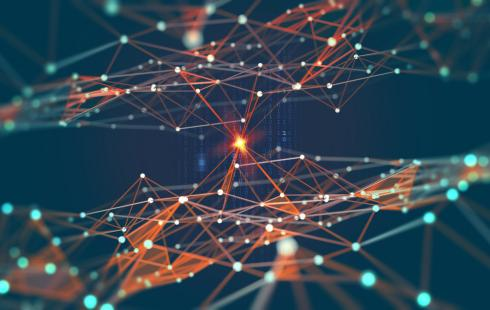

## Notebook III of III

This notebook is the III one in my series of work in this competition. As always shout out to amazing kernel authors present here at kaggle!! I got loads of inspiration from them. I believe this is the best thing about the ML community. The extent of collaboration and guidance one can seek here is inexplicable!!

## Previous works : 
* Dataset preparation(Notebook I) : 
**https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-one**

* Exploratory Data Analysis(Notebook II) : 
**https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-two?scriptVersionId=38737733**

**Please consider upvoting if you find the overall series of notebooks useful! I have tried explaining the steps performed in profound details.**

Thank you! 
Let's begin!!~~

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

/kaggle/input
/kaggle/input/siim-isic-melanoma-classification
/kaggle/input/siim-isic-melanoma-classification/train
/kaggle/input/siim-isic-melanoma-classification/jpeg
/kaggle/input/siim-isic-melanoma-classification/jpeg/train
/kaggle/input/siim-isic-melanoma-classification/jpeg/test
/kaggle/input/siim-isic-melanoma-classification/tfrecords
/kaggle/input/siim-isic-melanoma-classification/test


## Let's look at the libraries we need : 

* Numpy : For working on ndarrays. It's a base library in any Machine Learning application.
* Pandas : Handling csvs'. It's dataframe data structure allows us to quickly derieve insights from our csv data.
* Matplotlib, Seaborn and Plotly : Plotting libraries for Python3.
* cv2 : Open source library for Image Processing and Computer Vision.
* Tensorflow : A deep learning framework for designing models and input data pipelines.
* partial : Basically used when there are cases of optional arguments. This keeps the pipeline intact. 
* sklearn : This is for yet another beautifully optimized ML library having off-the-shelf ML algorithms implemented. 
* tqdm : For visualizing progress during a loop or any iteration for that matters.
* gc : Garbage collection. This is for freeing the underlying memory from temporary variables and references.

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import cv2
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
from functools import partial
import sklearn
from tqdm import tqdm_notebook as tqdm
import gc
%matplotlib inline

Let's initialize our TPU !!

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [4]:
print('Device:', tpu.master())
print('Number of replicas:', strategy.num_replicas_in_sync)
print("Version of Tensorflow used : ", tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
Version of Tensorflow used :  2.2.0


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]
SHAPE = [256, 256]

In [6]:
print("Batch Size = ", BATCH_SIZE)
print("GCS Path = ", GCS_PATH)

Batch Size =  128
GCS Path =  gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38


Upload the updated training and test csv obtained in the EDA notebook. There we filled the missing values and saved them in our custom dataset folder.

**Dataset : https://www.kaggle.com/fireheart7/melanoma-image-insights**

In [7]:
train = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/train.csv"))
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [8]:
test = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/test.csv"))
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [11]:
train_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

In [12]:
image_names = train["image_name"].values + ".jpg"
random_images = [np.random.choice(image_names) for i in range(4)] # Generates a random sample from a given 1-D array
random_images 

['ISIC_3260696.jpg',
 'ISIC_6270484.jpg',
 'ISIC_2145730.jpg',
 'ISIC_2069765.jpg']

## Viewing Our Training Images : 

Let's plot some of our training images : 

In [13]:
sample_images = []

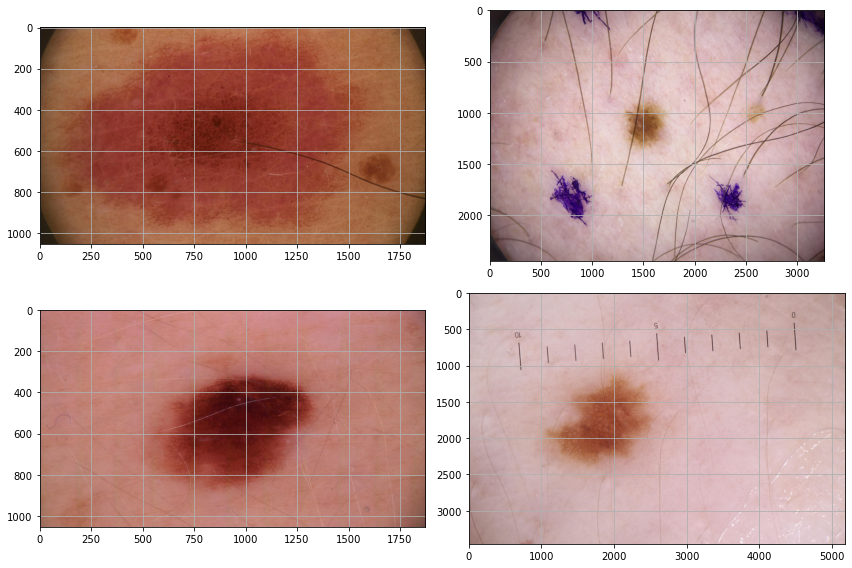

In [14]:
plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i + 1) 
    image = cv2.imread(os.path.join(train_dir, random_images[i]))
    # cv2 reads images in BGR format. Hence we convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample_images.append(image)
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

## Image Denoising :

Many image smoothing techniques like Gaussian Blurring, Median Blurring etc were good to some extent in removing small quantities of noise. In those techniques, we took a small neighbourhood around a pixel and performed some operations like gaussian weighted average, median of the values etc to replace the central element. In short, noise removal at a pixel was local to its neighbourhood.

There is a property of noise. **Noise is generally considered to be a random variable with zero mean.**

Suppose we hold a static camera to a certain location for a couple of seconds. This will give us plenty of frames, or a lot of images of the same scene. Then averaging all the frames, we compare the final result and first frame. Reduction in noise would be easily observed.

So idea is simple, we need a set of similar images to average out the noise. Considering a small window (say 5x5 window) in the image, chance is large that the same patch may be somewhere else in the image. Sometimes in a small neighbourhood around it. Hence, using these similar patches together averaging them can lead to an efficient denoised image.

This method is **Non-Local Means Denoising. It takes more time compared to blurring techniques, but the result are very satisfying.**

Denoising illustration :
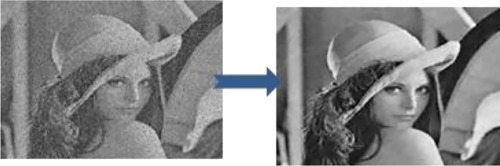 

## OpenCV implementation of the aforementioned approach :
cv2.fastNlMeansDenoisingColored() - Works on Colored images cv2.fastNlMeansDenoising() - Works on graysacle images

Common arguments are:

* h : parameter deciding filter strength. Higher h value removes noise better, but removes details of image also. (10 is ok)
* hForColorComponents : same as h, but for color images only. (normally same as h)
* templateWindowSize : should be odd. (recommended 7)
* searchWindowSize : should be odd. (recommended 21)

In [15]:
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

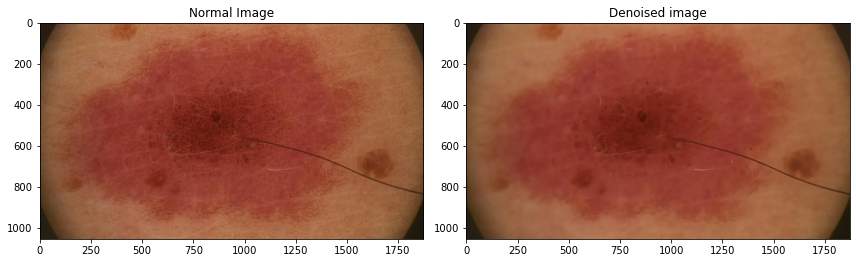

In [16]:
sample_image = cv2.imread(os.path.join(train_dir, random_images[0]))
# cv2 reads images in BGR format. Hence we convert it to RGB
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
denoised_image = non_local_means_denoising(sample_image)


plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image")

plt.subplot(1,2,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised image")    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout() 

## Local Histogram Pre-Processing

First of all, why can't we apply histogram equalization directly to an RGB image?
Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is incorrect. *Equalization involves intensity values of the image, not the color components*. 

So for a simple RGB color image, histogram equalization cannot be applied directly on the channels.*It needs to be applied in such a way that the intensity values are equalized without disturbing the color balance of the image. So, the first step is to convert the color space of the image from RGB into one of the color spaces that separates intensity values from color components. Some of the possible options are HSV/HLS, YUV, YCbCr, etc. YCbCr is preferred as it is designed for digital images. Perform histogram equalization on the intensity plane Y. Now convert the resultant YCbCr image back to RGB.*

(Excerpt taken from :

https://prateekvjoshi.com/2013/11/22/histogram-equalization-of-rgb-images/ )

An illustration of histogram equalization : **Observe the intensity difference**
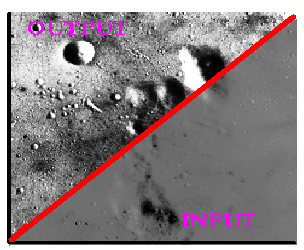 

Here the third one is actually local histogram equalization, where we equalize intensities inside a rolling window of certain dimension instead of the whole image at once.

In [17]:
def histogram_equalization(image) : 
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    y_channel = image_ycrcb[:,:,0] # apply local histogram processing on this channel
    cr_channel = image_ycrcb[:,:,1]
    cb_channel = image_ycrcb[:,:,2]
    
    # Local histogram equalization
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8,8))
    equalized = clahe.apply(y_channel)
    equalized_image = cv2.merge([equalized, cr_channel, cb_channel])
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YCR_CB2RGB)
    return equalized_image

In [18]:
equalized_image = histogram_equalization(denoised_image)

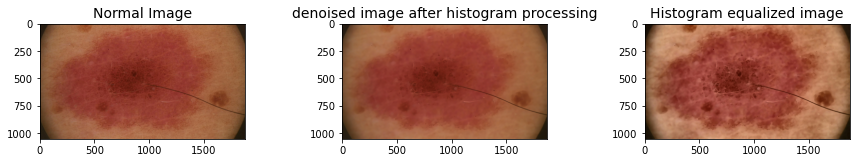

In [19]:
plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image", fontsize = 14)

plt.subplot(1,3,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("denoised image after histogram processing", fontsize = 14)

plt.subplot(1,3,3)  
plt.imshow(equalized_image, cmap = "gray")
plt.grid(False)
plt.title("Histogram equalized image", fontsize = 14)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

## Image Segmentation :

Is the technique of dividing or partitioning an image into parts, called segments. It is mostly useful for applications like image compression or object recognition, because for these types of applications, it is inefficient to process the whole image.

We will use **K-means clustering algorithm** to segment the images.

K-Means Segmentation Approach Using OpenCV

* `samples` : It should be of np.float32 data type, and each feature should be put in a single column. Here we have 3 channels, so every channel features have to be in one column. So, total columns we have are 3, while we don't care about the number of rows, hence -1. So, shape : (-1, 3).

* `nclusters(K)` : Number of clusters required at end.

* `criteria` : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `( type, max_iter, epsilon )`:

Type of termination criteria. It has 3 flags as below:

1. `cv.TERM_CRITERIA_EPS` - stop the algorithm iteration if specified accuracy, epsilon, is reached.
2. `cv.TERM_CRITERIA_MAX_ITER` - stop the algorithm after the specified number of iterations, max_iter.
3. `cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER` - stop the iteration when any of the above condition is met.

*max_iter - An integer specifying maximum number of iterations. epsilon - Required accuracy*

* `attempts` : Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.

* `flags` : This flag is used to specify how initial centers are taken. Normally two flags are used for this : cv.KMEANS_PP_CENTERS and cv.KMEANS_RANDOM_CENTERS.

****

Output parameters :

* `compactness` : It is the sum of squared distance from each point to their corresponding centers.
* `labels` : This is the label array (same as 'code' in previous article) where each element marked '0','1'.....
* `centers` : This is array of centers of clusters.

In [20]:
def segmentation(image, k, attempts) : 
    vectorized = np.float32(image.reshape((-1, 3)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    res , label , center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((image.shape))
    return segmented_image

Text(0.5, 1.0, 'de Noised Image')

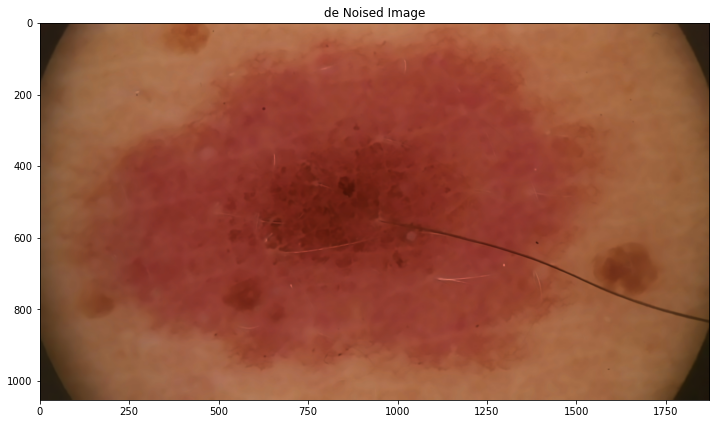

In [21]:
plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("de Noised Image")

Text(0.5, 1.0, 'Segmented Image with k = 5')

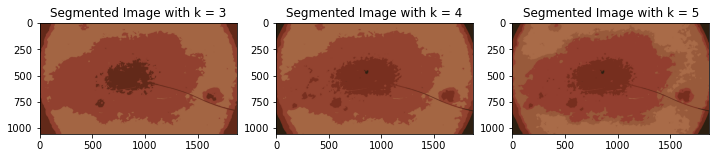

In [22]:
plt.figure(figsize = (12, 8))
segmented_image = segmentation(denoised_image, 3, 10) # k = 3, attempt = 10
plt.subplot(1,3,1)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 3")

segmented_image = segmentation(denoised_image, 4, 10) # k = 4, attempt = 10
plt.subplot(1,3,2)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 4")

segmented_image = segmentation(denoised_image, 5, 10) # k = 5, attempt = 10
plt.subplot(1,3,3)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 5")

## Tensorflow Records : 

Many folks don't really understand this! So let's have some insight before we actually dive into creating our model.

**What is Tensorflow Record?**

It's Tensorflow's binary storage format for your data. 

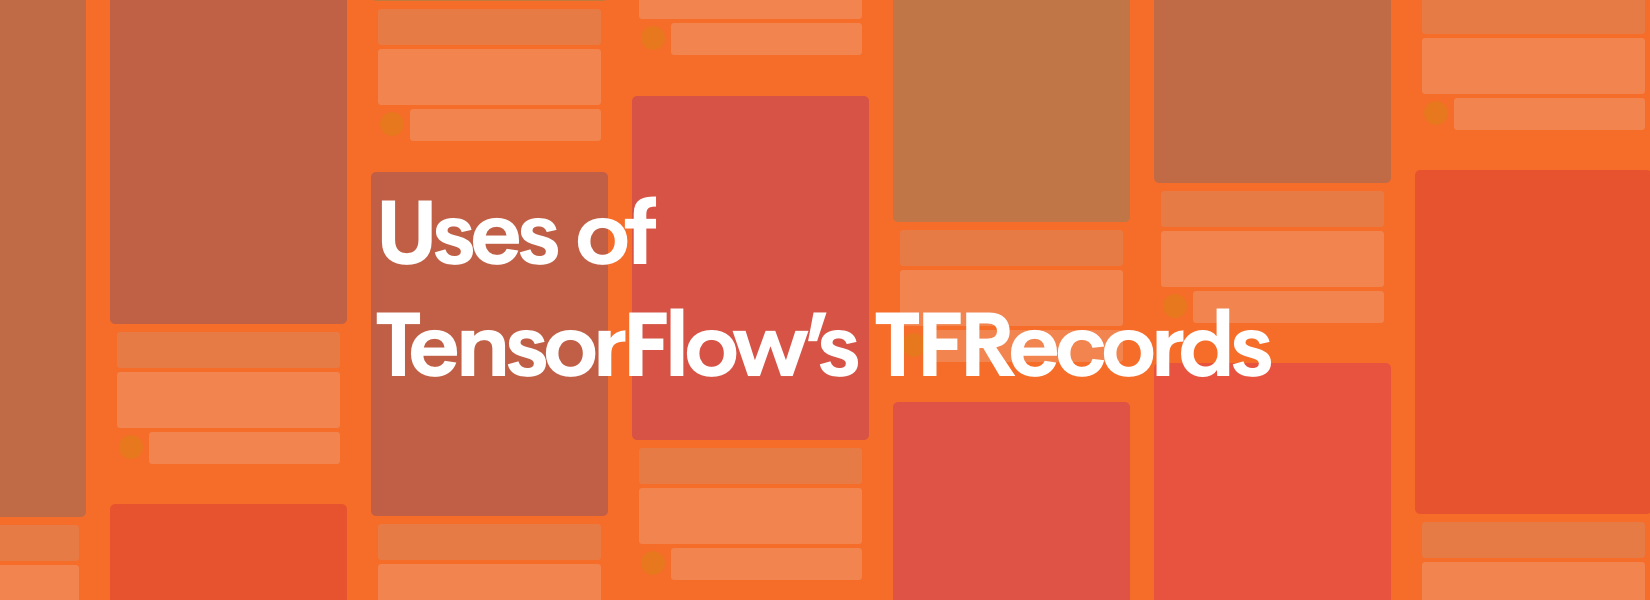

**Okay, so what's the endgame? Aren't JPEG, PNG also storage formats? What makes this one special ?**

Well, short answer : It's Google's.
Ummm.. a little longer answer would be that binary storage data takes up relatively low space on your disk, and hence it takes less time to copy and can be read much more efficiently! Moreover, the *tensorflow* framework is optimized to handle tfrecords amazingly well. 

The datasets that are too large to be stored fully in memory, this is an advantage as only the data that is required at the time (e.g. a batch) is loaded from disk and then processed. 

Another major advantage of TFRecords is that it is possible to store sequence data — for instance, a time series or word encodings — in a way that allows for very efficient and (from a coding perspective) convenient import of this type of data.

*In a nutshell, it's cool !*

## TFRecord = Array of Examples : 

A TFRecord file contains an array of `Examples`. `Example` is a data structure for representing a record, like an observation in a training or test dataset. A record is represented as a set of features, each of which has a name and can be an array of bytes, floats, or 64-bit integers. 

To summarize:

* An Example contains Features.
* Features is a mapping from the feature names stored as strings to Features.

These relations are defined in `example.proto` and `feature.proto` in the TensorFlow's source code, along with extensive comments. As the extension `.proto` suggests, these definitions are based on `protocol buffers`.

## Why Protocol Buffers?

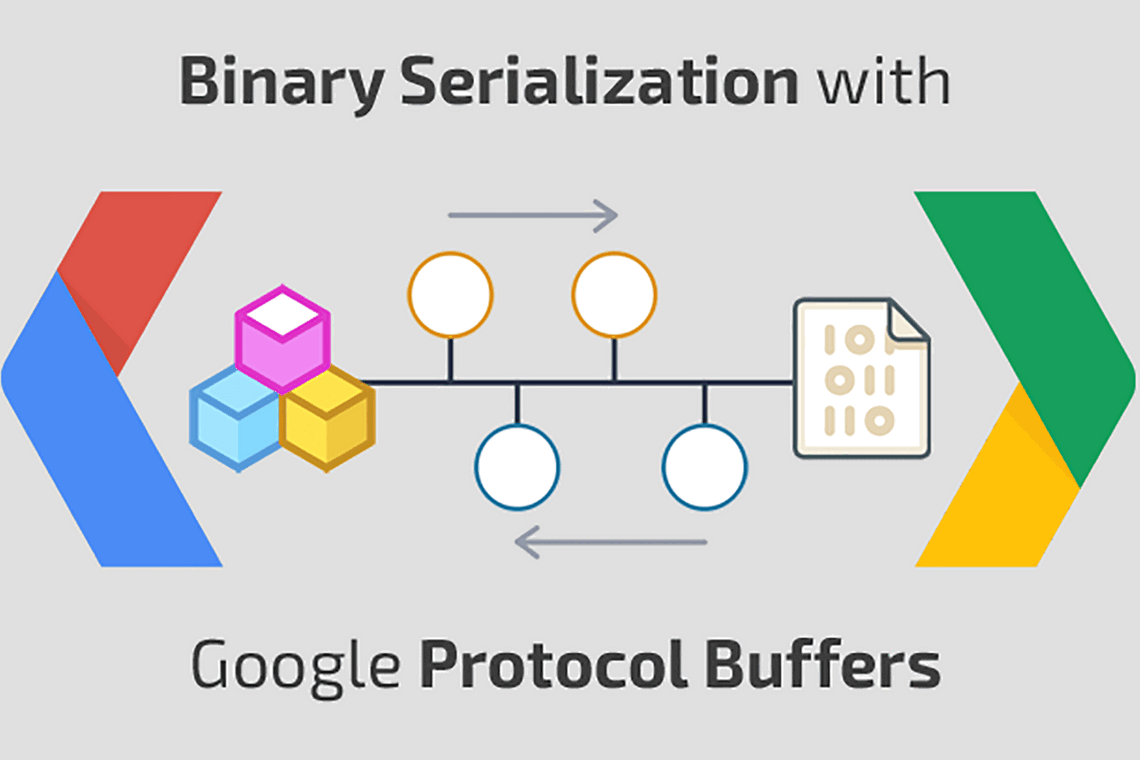 

Google’s Protocol buffers are a serialization scheme for structured data. In other words, protocol buffers are used for serializing structured data into a byte array, so that they can be sent over the network or stored as a file. In this sense, it is similar to JSON, XML.

**Protocol buffers can offer a lot faster processing speed compared to text-based formats like JSON or XML.**

In [23]:
from sklearn.model_selection import train_test_split 
training_files, validation_files = train_test_split(tf.io.gfile.glob(GCS_PATH + "/tfrecords/train*.tfrec"),
                                                   test_size = 0.1, random_state = 42)

testing_files = tf.io.gfile.glob(GCS_PATH + "/tfrecords/test*.tfrec")

print("Number of training files = ", len(training_files))
print("Number of validation files = ", len(validation_files))
print("Number of test files = ", len(testing_files))

Number of training files =  14
Number of validation files =  2
Number of test files =  16


In [24]:
def decode_image(image) : 
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.reshape(image, [IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    return image

In [25]:
sample_images[0].shape

(1053, 1872, 3)

We observe our training_files object stores all tfrecord files. Let's pick one to analyze. 

In [26]:
training_files

['gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train05-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train14-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train13-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train11-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train08-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train09-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train02-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train15-2061.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train04-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train07-2071.tfrec',
 'gs://kds

In [27]:
sample_picked = training_files[0]
sample_picked

'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train05-2071.tfrec'

A TFRecord file can be read using **tf.data.TFRecordDataset** class.

In [28]:
file = tf.data.TFRecordDataset(sample_picked)
file

<TFRecordDatasetV2 shapes: (), types: tf.string>

* At this point the dataset contains serialized **tf.train.Example** messages. When iterated over it returns these as scalar string tensors. 

*This means that it is composed of a tensors and we need to parse it in order to make some meaning of it. For that very purpose it becomes mandatory to define a feature_description as tensorflow TFRecord datasets use Tensorflow's graph execution instead of Eager execution**. 

Basically : 

* Eager execution is what has been done so far. You write a statement and execute it. The results appear instantaneously. This imperative way of programming is inspired from Python3.

* On the other hand, Graph execution is another way of defining control flow where we construct a structure in which we define how a tensor flows( hence the name tensorflow, I guess). This means say at the first node there has to be addition of two tensors, at the second rescaling, third divison and in the final node an activation function is there to return the final answer. 

* Graph execution is extremely useful in areas where Python interpreter is absent like in Android applications, and so on. Here, due to computational graphs, tensorflow models can still be deployed. This makes tensorflow an amazing tool for model deployment. However, that's a story for another day.

In [29]:
feature_description = {"image" : tf.io.FixedLenFeature([], tf.string), 
                      "target" : tf.io.FixedLenFeature([], tf.int64)}

In [30]:
def parse_function(example) : 
    # The example supplied is parsed based on the feature_description above.
    return tf.io.parse_single_example(example, feature_description)

In [31]:
parsed_dataset = file.map(parse_function)
parsed_dataset

<MapDataset shapes: {image: (), target: ()}, types: {image: tf.string, target: tf.int64}>

In [32]:
def read_tfrecord(example, labeled) : 
    if labeled == True : 
        tfrecord_format = {"image" : tf.io.FixedLenFeature([], tf.string),
                           "target" : tf.io.FixedLenFeature([], tf.int64)}
    else:
        tfrecord_format = {"image" : tf.io.FixedLenFeature([], tf.string),
                          "image_name" : tf.io.FixedLenFeature([], tf.string)}
    
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled == True : 
        label = tf.cast(example["target"], tf.int32)
        return image, label
    else:
        image_name = example["image_name"]
        return image, image_name     

Some key modules used :

* **tf.data.Options()** : An Options object can be, for instance, used to control which graph optimizations to apply. 

* **.experiemental_deterministic** : `experiemntal_deterministic` refers to whether the outputs need to be produced in deterministic order. If None, defaults to True. Here, the data is unordered, hence we don't need to process it in an order which may slow down our speed. 

* **TFRecordDataset** : A Dataset comprising records from one or more TFRecord files.

* **num_parallel_reads** argument in TFRecordDataset : A tf.int64 scalar representing the number of files to read in parallel.

TFRecord files of training and testing are mixed. Therefore we don't know whether the file being input has a label of malignant/benign associated with it or not! Hence, we will supply both example and label to it, and simply set the label to False in the function call stack; in case label is absent. 

For test images, we will return the image name instead of the label.

Note below we have a condition for disabling the order. This will come in handy, as for training and validation purposes, we don't need to take care of the order. However, for test images we have to submit the predictions and they have to be in order. Hence, for them `experimental_deterministic will remain true`. The role of `experimental_deterministic` setting is to `disable data order reinforcement.`

More detail can be found at : **https://www.kaggle.com/docs/tpu**

In [33]:
def load_dataset(filenames, labeled, ordered):
    ignore_order = tf.data.Options()
    if ordered == False: # dataset is unordered, so we ignore the order to load data quickly.
        ignore_order.experimental_deterministic = False # This disables the order and enhances the speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) 
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [34]:
def image_augmentation(image, label) :     
    image = tf.image.resize(image, SHAPE)
    image = tf.image.random_flip_left_right(image)
    return image, label

# Load The Datasets : 

* **map( )** : This transformation applies map_func to each element of this dataset, and returns a new dataset containing the transformed elements

* **repeat( )** : Repeats this dataset so each original value is seen count times.

* **shuffle( )** : Randomly shuffles the elements of this dataset.

* **batch( )** : Combines consecutive elements of this dataset into batches.

* **prefetch( )** : Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. prefetch( ) doesn’t allow CPU stand idle. When model is training prefetch continue prepare data while GPU is busy.

* **cache( )** : The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data. When caching to a file, the cached data will persist across runs. Even the first iteration through the data will read from the cache file. 

In [35]:
def get_training_dataset() : 
    dataset = load_dataset(training_files, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [36]:
def get_validation_dataset() : 
    dataset = load_dataset(validation_files, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [37]:
def get_test_dataset() : 
    dataset = load_dataset(testing_files, labeled = False, ordered = True)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [38]:
training_dataset = get_training_dataset()

In [39]:
validation_dataset = get_validation_dataset()

In [40]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

num_training_images = count_data_items(training_files)
num_validation_images = count_data_items(validation_files)
num_testing_images = count_data_items(testing_files)

STEPS_PER_EPOCH_TRAIN = num_training_images // BATCH_SIZE
STEPS_PER_EPOCH_VAL = num_validation_images // BATCH_SIZE

print("Number of Training Images = ", num_training_images)
print("Number of Validation Images = ", num_validation_images)
print("Number of Testing Images = ", num_testing_images)
print("\n")
print("Numer of steps per epoch in Train = ", STEPS_PER_EPOCH_TRAIN)
print("Numer of steps per epoch in Validation = ", STEPS_PER_EPOCH_VAL)

Number of Training Images =  28984
Number of Validation Images =  4142
Number of Testing Images =  10982


Numer of steps per epoch in Train =  226
Numer of steps per epoch in Validation =  32


In [41]:
image_batch, label_batch = next(iter(training_dataset))

In [42]:
def show_batch(image_batch, label_batch) :
    plt.figure(figsize = (20, 20))
    for n in range(8) : 
        ax = plt.subplot(2,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0 : 
            plt.title("BENIGN")
        else:
            plt.title("MALIGNANT")
    plt.grid(False)
    plt.tight_layout()       

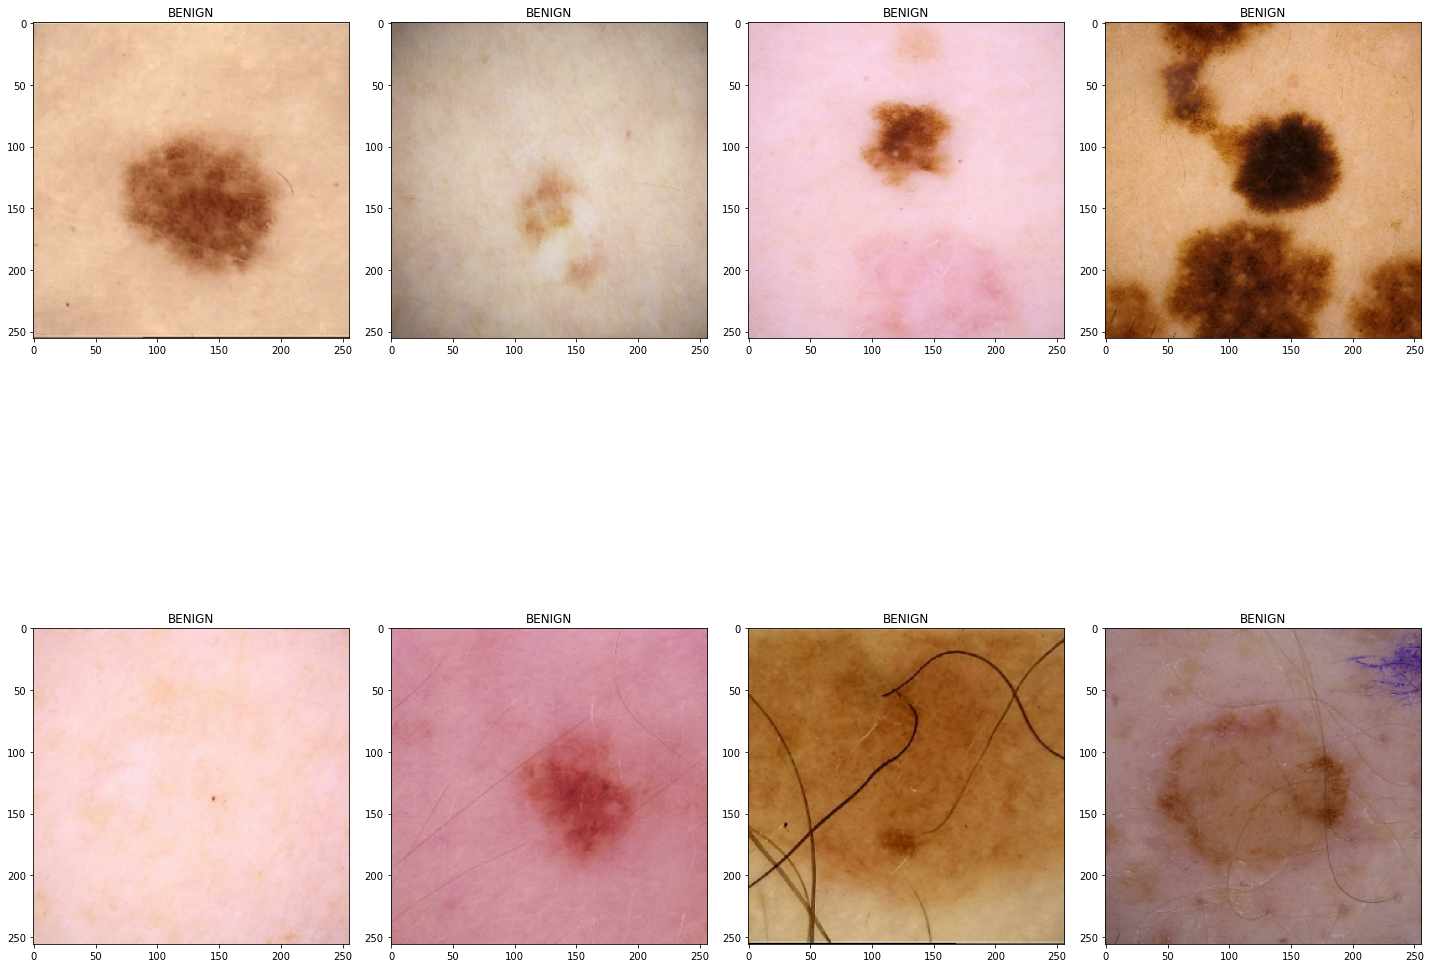

In [43]:
show_batch(image_batch.numpy(), label_batch.numpy())

Let's free up some memory

In [44]:
del image_batch
del label_batch
gc.collect()

38410

# Model Construction : 

## Malignant VS Benign Imbalance Analysis 

In [45]:
malignant = len(train[train["target"] == 1])
benign = len(train[train["target"] == 0 ])
total = len(train) 

print("Malignant Cases in Train Data = ", malignant)
print("Benign Cases In Train Dataset = ",benign)
print("Total Cases In Train Dataset = ",total)
print("Ratio of Malignant to Benign = ",malignant/benign)

Malignant Cases in Train Data =  584
Benign Cases In Train Dataset =  32542
Total Cases In Train Dataset =  33126
Ratio of Malignant to Benign =  0.017946038965029807


## Class Weights Initialization : 

We saw earlier that malignant cases happen to be far less than the benign ones. Hence, we ought to set relatively heavy weights for malignant cases compared to the benign ones. This will encourage the model to pay more attention to malignant ones.

`According to official Tensorflow documentation : `

*Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class*.

In [46]:
weight_malignant = (total/malignant)/2.0
weight_benign = (total/benign)/2.0

class_weight = {0 : weight_benign , 1 : weight_malignant}

print("Weight for benign cases = ", class_weight[0])
print("Weight for malignant cases = ", class_weight[1])

Weight for benign cases =  0.5089730194825149
Weight for malignant cases =  28.361301369863014


## Defining CallBacks : 

A callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference. Callbacks are useful to get a view on internal states and statistics of the model during training.

This can be used to stop predictions when there is no change in the desired metric over a certain epoch range. This is amazingly useful in order to avoid `overfitting`. 

Here we use : 

* ModelCheckPoint : Callback to save the Keras model or model weights at some frequency.
* EarlyStopping : Stop training when a monitored metric has stopped improving.

In [47]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(patience = 15, verbose = 0, restore_best_weights = True)

callbacks_lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_auc", factor = 0.1, patience = 10, 
                                                          verbose = 0, min_lr = 1e-6)

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint("melanoma_weights.h5",
                                                         save_weights_only=True, monitor='val_auc',
                                                         mode='max', save_best_only = True)

## Setting Evaluation Metric: 

*This is taken from Amy Jang's notebook as mentioned earlier.*

*Notebook : https://www.kaggle.com/amyjang/tensorflow-transfer-learning-melanoma*

When we compile our model, we do not want our metric to be accuracy. If we run the model, with an accuracy metric, it will give us false confidence in our model. If we look at the dataset, we see that 98% of the images are classifed as benign, 0. Now, if accuracy was the sole determinant of our model, a model that always outputs 0 will achieve a high accuracy although the model is not good.

The competition scores the model by finding the area under the ROC curve, which is why our metric will be set to keras.metrics.AUC.

## Model Design : MobileNetV2

A supercool resource : **https://machinethink.net/blog/mobilenet-v2/**

## Bias Initialization : 

Since the dataset is heavily imbalanced, we may want to assign different weights to different classes. Setting an initial bias is important in such cases.

In [48]:
with strategy.scope() : 
    bias = np.log(malignant/benign)
    bias = tf.keras.initializers.Constant(bias)
    base_model = tf.keras.applications.ResNet50(input_shape = (SHAPE[0], SHAPE[1], 3), include_top = False,
                                               weights = "imagenet")
    base_model.trainable = False
    model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dense(20, activation = "relu"),
                                 tf.keras.layers.Dropout(0.4),
                                 tf.keras.layers.Dense(10, activation = "relu"),
                                 tf.keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)                                     
                                ])
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-2), loss = "binary_crossentropy", metrics = [tf.keras.metrics.AUC(name = 'auc')])
    model.summary()
    
    EPOCHS = 500
    history = model.fit(training_dataset, epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
                       validation_data = validation_dataset, validation_steps = STEPS_PER_EPOCH_VAL,
                       callbacks = [callback_early_stopping, callbacks_lr_reduce, callback_checkpoint],
                       class_weight = class_weight)

94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                40980     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________

Let's observe the number of epochs our model ran for before callbacks stopped the execution due to no further significant improvement in validation_accuracy.

In [49]:
n_epochs_it_ran_for = len(history.history['loss'])
n_epochs_it_ran_for

16

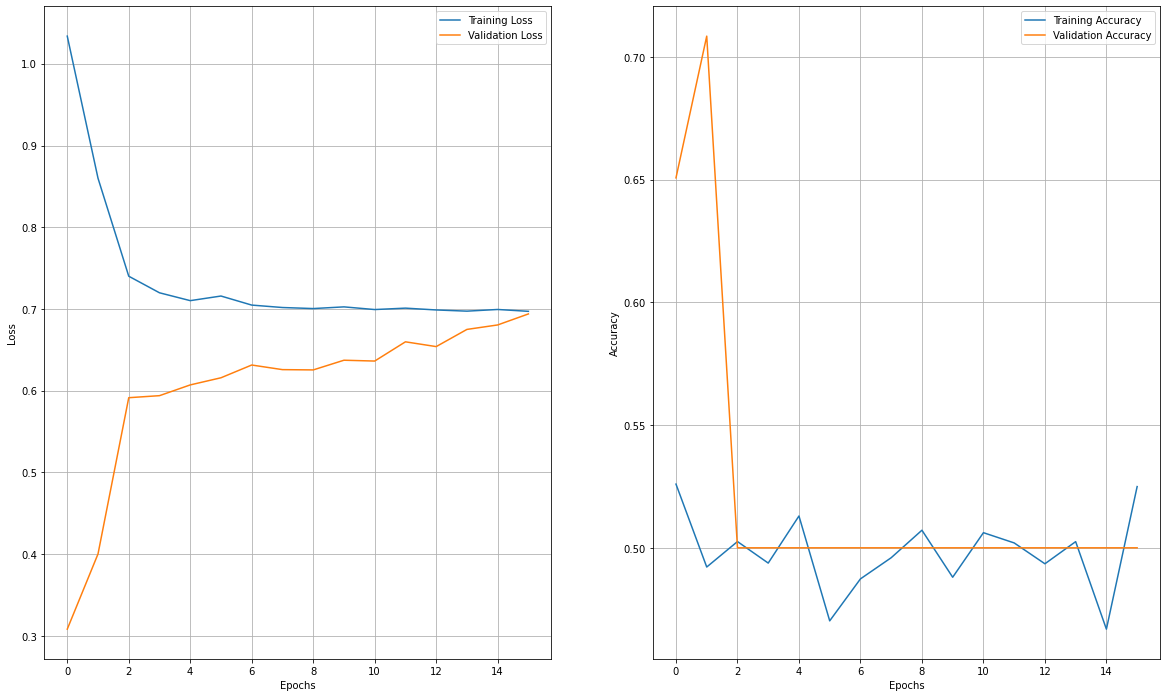

In [50]:
X = np.arange(0,n_epochs_it_ran_for,1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, history.history["loss"], label = "Training Loss")
plt.plot(X, history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, history.history["auc"], label = "Training Accuracy")
plt.plot(X, history.history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

Due to callbacks, best weights are automatically restored!

In [51]:
testing_dataset = get_test_dataset()
testing_dataset_images = testing_dataset.map(lambda image, image_name : image)
testing_image_names = testing_dataset.map(lambda image, image_name : image_name)

In [52]:
resulting_probabilities = model.predict(testing_dataset_images, verbose = 1)

86/86 [==============================] - 13s 152ms/step


In [53]:
len(resulting_probabilities)

10982

In [54]:
sample_submission_file = pd.read_csv("../input/siim-isic-melanoma-classification/sample_submission.csv")
sample_submission_file.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [55]:
del sample_submission_file["target"]
sample_submission_file.head()

,image_name
0,ISIC_0052060
1,ISIC_0052349
2,ISIC_0058510
3,ISIC_0073313
4,ISIC_0073502


In [56]:
testing_image_names

<MapDataset shapes: (None,), types: tf.string>

In [57]:
testing_image_names = np.concatenate([x for x in testing_image_names], axis=0)
testing_image_names = np.array(testing_image_names)

In [58]:
decoded_test_names = []
for names in testing_image_names : 
    names = names.decode('utf-8')
    decoded_test_names.append(names)
decoded_test_names = np.array(decoded_test_names)
del testing_image_names

In [59]:
len(decoded_test_names), type(decoded_test_names), decoded_test_names.shape

(10982, numpy.ndarray, (10982,))

In [60]:
decoded_test_names

array(['ISIC_6381819', 'ISIC_5583376', 'ISIC_6408546', ...,
       'ISIC_8285611', 'ISIC_2076526', 'ISIC_8959686'], dtype='<U12')

In [61]:
testing_image_names = pd.DataFrame(decoded_test_names, columns=["image_name"])
testing_image_names.head()

,image_name
0,ISIC_6381819
1,ISIC_5583376
2,ISIC_6408546
3,ISIC_6932354
4,ISIC_8191278


In [62]:
pred_dataframe = pd.DataFrame({"image_name" : decoded_test_names, 
                               "target" : np.concatenate(resulting_probabilities)})
pred_dataframe

,image_name,target
0,ISIC_6381819,0.251262
1,ISIC_5583376,0.252657
2,ISIC_6408546,0.253129
3,ISIC_6932354,0.250105
4,ISIC_8191278,0.256415
...,...,...
10977,ISIC_1581247,0.251262
10978,ISIC_8432732,0.265467
10979,ISIC_8285611,0.261397
10980,ISIC_2076526,0.249637


In [63]:
sample_submission_file = sample_submission_file.merge(pred_dataframe, on = "image_name")
sample_submission_file.to_csv("submission.csv", index = False)
sample_submission_file.head()

,image_name,target
0,ISIC_0052060,0.253349
1,ISIC_0052349,0.255939
2,ISIC_0058510,0.260434
3,ISIC_0073313,0.252422
4,ISIC_0073502,0.248485


## The journey continues!!

The pre-processing we did earlier, I'll soon share the dataset of denoised, histogram equalized images. Then using the approach here in this notebook, we will use tf.data API to directly train on them!!

Stay Tuned!~~

In the meantime, you can view my other works in the SIIM ISIC Melanoma Challenge : 

* **https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-one**
* **https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-two**